<a href="https://colab.research.google.com/github/lucasgneccoh/FNC_nlp_project/blob/main/notebooks/UCLNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import os
%cd /content
!git clone https://github.com/lucasgneccoh/FNC_nlp_project.git

os.chdir("/content/FNC_nlp_project")

/content
fatal: destination path 'FNC_nlp_project' already exists and is not an empty directory.


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras as keras
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Data

## Loading data

In [3]:
train_bodies = pd.read_csv('data/FNC_data/train_bodies.csv') # BodyID, Body
train_stances = pd.read_csv('data/FNC_data/train_stances.csv') # Headline, BodyID, Stance

test_bodies = pd.read_csv('data/FNC_data/competition_test_bodies.csv') # BodyID, Body
test_stances = pd.read_csv('data/FNC_data/competition_test_stances.csv') # Headline, BodyID, Stance

## Data preprocessing

we want to create our vectorised representations of the training and test sets

So first we set the stop words, normalising the tables,then calculating the tf and tfidf representations

In [4]:
# data preprocessing parameters
lim_unigram = 5000
stop_words = [
        "a", "about", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along",
        "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
        "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as", "at", "back", "be",
        "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
        "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom", "but", "by", "call", "can", "co",
        "con", "could", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight",
        "either", "eleven", "else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
        "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill", "find", "fire", "first", "five", "for",
        "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had",
        "has", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself",
        "him", "himself", "his", "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed", "interest",
        "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made",
        "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much",
        "must", "my", "myself", "name", "namely", "neither", "nevertheless", "next", "nine", "nobody", "now", "nowhere",
        "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours",
        "ourselves", "out", "over", "own", "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see",
        "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some",
        "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take",
        "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby",
        "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though",
        "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve",
        "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what",
        "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon",
        "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will",
        "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"
        ]

We process the data in normalized tables (pandas Dataframes and Series)  
In the end we have 3 objects for the train set and 3 for the test set  
if X is 'train' or 'test', we have:  
- X_headlines: Series with the headlines   
- X_bodies: Series with the bodies
- X_stances: relation table with the X_healine and X_bodies indexes ('head id' and 'body id') and the labels ('stance')

In [5]:
cat = pd.Categorical(train_stances['Headline'])
train_headlines = pd.Series(cat.categories,name='headline')
train_stances['head id'] = cat.codes
train_stances = train_stances.drop(columns='Headline')

cat = pd.Categorical(train_stances['Body ID'])
train_bodies = pd.Series([train_bodies['articleBody'][(train_bodies['Body ID'] == i)].values[0] for i in cat.categories]
    ,name='article body')
train_stances['body id'] = cat.codes
train_stances = train_stances.drop(columns='Body ID')

cat = pd.Categorical(train_stances['Stance'])
stances = pd.Series(cat.categories,name='stance')
train_stances['stance'] = cat.codes
train_stances = train_stances.drop(columns='Stance')

cat = pd.Categorical(test_stances['Headline'])
test_headlines = pd.Series(cat.categories,name='headline')
test_stances['head id'] = cat.codes
test_stances = test_stances.drop(columns='Headline')

cat = pd.Categorical(test_stances['Body ID'])
test_bodies = pd.Series([test_bodies['articleBody'][(test_bodies['Body ID'] == i)].values[0] for i in cat.categories]
    ,name='article body')
test_stances['body id'] = cat.codes
test_stances = test_stances.drop(columns='Body ID')

cat = pd.Categorical(test_stances['Stance'], categories = stances)
test_stances['stance'] = cat.codes
test_stances = test_stances.drop(columns='Stance')


Now we create vectorizers and BOW and TF arrays for train set

In [6]:
bow_vectorizer = CountVectorizer(max_features=lim_unigram, stop_words=stop_words)
bow = bow_vectorizer.fit_transform(list(train_headlines) + list(train_bodies))  # Train set only

tfreq_vectorizer = TfidfTransformer(use_idf=False).fit(bow)
tfreq = tfreq_vectorizer.transform(bow).toarray()  # Train set only

tfidf_vectorizer = TfidfVectorizer(max_features=lim_unigram, stop_words=stop_words).\
    fit(list(train_headlines) + list(train_bodies) + \
        list(test_headlines)  + list(test_bodies)
        )  # Train and test sets

We encode the headlines and bodies

In [7]:
bow = bow_vectorizer.transform(list(train_headlines)).toarray()
head_vect_train = tfreq_vectorizer.transform(bow).toarray()
bow = bow_vectorizer.transform(list(test_headlines)).toarray()
head_vect_test = tfreq_vectorizer.transform(bow).toarray()
bow =  bow_vectorizer.transform(list(train_bodies)).toarray()
body_vect_train = tfreq_vectorizer.transform(bow).toarray()
bow =  bow_vectorizer.transform(list(test_bodies)).toarray()
body_vect_test = tfreq_vectorizer.transform(bow).toarray()

head_tfidf_train = tfidf_vectorizer.transform(list(train_headlines)).toarray()
head_tfidf_test = tfidf_vectorizer.transform(list(test_headlines)).toarray()
body_tfidf_train = tfidf_vectorizer.transform(list(train_bodies)).toarray()
body_tfidf_test = tfidf_vectorizer.transform(list(test_bodies)).toarray()
cos_sim = lambda i : cosine_similarity(
    head_tfidf_train[train_stances['head id'][i]].reshape(1,-1),
    body_tfidf_train[train_stances['body id'][i]].reshape(1,-1)
    ).squeeze()
tfidf_cos_train = np.array([cos_sim(i) for i in range(len(train_stances))])
cos_sim = lambda i : cosine_similarity(
    head_tfidf_test[test_stances['head id'][i]].reshape(1,-1),
    body_tfidf_test[test_stances['body id'][i]].reshape(1,-1)
    ).squeeze()
tfidf_cos_test = np.array([cos_sim(i) for i in range(len(test_stances))])

Finally we use our vector representations to compute the train and test set

In [8]:
train_set = np.c_[head_vect_train[train_stances['head id']],
                  body_vect_train[train_stances['body id']],
                  tfidf_cos_train
                  ]
test_set = np.c_[head_vect_test[test_stances['head id']],
                 body_vect_test[test_stances['body id']],
                 tfidf_cos_test
                 ]

## memory check and clean
after this preprocessing, we can discard some heavy variables to free some memory

In [9]:
del tfreq, body_vect_train, body_tfidf_train, \
    head_tfidf_train, head_vect_train, bow, \
    body_vect_test, body_tfidf_test, head_vect_test, \
    head_tfidf_test


and check if what is left in memory is pertinent

In [10]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                     train_set:  3.7 GiB
                      test_set:  1.9 GiB
                  train_bodies:  6.2 MiB
                   test_bodies:  3.4 MiB
               tfidf_cos_train: 390.5 KiB
                 train_stances: 244.2 KiB
               train_headlines: 243.1 KiB
                tfidf_cos_test: 198.6 KiB
                test_headlines: 135.9 KiB
                  test_stances: 124.2 KiB


# model, training and results


## model definition

we set the parameters

In [11]:
display_summary = True
target_size = 4 # 4 different classes, (stances)
hidden_size = 100 # hidden layer width
train_keep_prob = 0.6 # for dropouts
l2_alpha = 0.00001 # regularization parameter
learn_rate = 0.01 # learning rate
clip_ratio = 5 # clip ratio for the gradient norm clipping
batch_size_train = 512 # pretty self-explanatory
epochs = 90 # number of epochs for training

We define the model with just one hiden layer as in the UCLNLP solution

In [12]:
feature_size = train_set.shape[1]
regul = keras.regularizers.l2(l2_alpha)

input = keras.Input(shape = (feature_size,), name='features')
hidden = keras.layers.Dense(hidden_size, activation='relu',kernel_regularizer=regul)(input)
hidden = keras.layers.Dropout(1-train_keep_prob, name = 'hidden')(hidden)
output = keras.layers.Dense(target_size,kernel_regularizer=regul)(hidden)
output = keras.layers.Dropout(1-train_keep_prob, name = 'output')(output)
softmax = keras.layers.Activation('softmax', name='classifier')(output)

model = keras.Model(inputs=input, outputs=softmax)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits='True')
model.compile(optimizer = keras.optimizers.Adam(learning_rate=learn_rate, clipnorm=clip_ratio),
            loss=loss)

if display_summary : model.summary ()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, 10001)]           0         
_________________________________________________________________
dense (Dense)                (None, 100)               1000200   
_________________________________________________________________
hidden (Dropout)             (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
_________________________________________________________________
output (Dropout)             (None, 4)                 0         
_________________________________________________________________
classifier (Activation)      (None, 4)                 0         
Total params: 1,000,604
Trainable params: 1,000,604
Non-trainable params: 0
___________________________________________________

## Train

In [13]:
history = model.fit(train_set, train_stances['stance'].to_numpy(),batch_size_train,epochs,validation_data=(test_set, test_stances['stance'].to_numpy()))

Epoch 1/90
98/98 [==============================] - 10s 92ms/step - loss: 0.8508 - val_loss: 0.4872
Epoch 2/90
98/98 [==============================] - 8s 84ms/step - loss: 0.4816 - val_loss: 0.4623
Epoch 3/90
98/98 [==============================] - 8s 83ms/step - loss: 0.4420 - val_loss: 0.4210
Epoch 4/90
98/98 [==============================] - 8s 84ms/step - loss: 0.4299 - val_loss: 0.4341
Epoch 5/90
98/98 [==============================] - 8s 83ms/step - loss: 0.4178 - val_loss: 0.4188
Epoch 6/90
98/98 [==============================] - 8s 84ms/step - loss: 0.4229 - val_loss: 0.4167
Epoch 7/90
98/98 [==============================] - 8s 84ms/step - loss: 0.4110 - val_loss: 0.4217
Epoch 8/90
98/98 [==============================] - 8s 84ms/step - loss: 0.4104 - val_loss: 0.4295
Epoch 9/90
98/98 [==============================] - 8s 84ms/step - loss: 0.4046 - val_loss: 0.4553
Epoch 10/90
98/98 [==============================] - 8s 84ms/step - loss: 0.4083 - val_loss: 0.4541
Epoch 11

## results

We use the metric given for the challenge

In [14]:
def metric (X,Y, unrelated_index = 3) :
    lvl1 = 0.25 * ((X == unrelated_index ) == (Y == unrelated_index)).sum()
    lvl2 = 0.75 * ((X != unrelated_index) & (X == Y)).sum()
    return lvl1 + lvl2

res = metric(model.predict(test_set).argmax(1), test_stances['stance'], 3)
print(f'for this model the score is {res}, the baseline score was 9521.5')

for this model the score is 9549.75, the baseline score was 9521.5


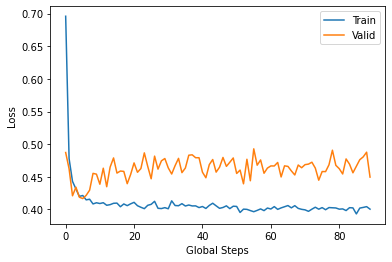

In [15]:
train_loss_list = history.history['loss']
valid_loss_list = history.history['val_loss']
global_steps_list = list(range(len(train_loss_list)))

plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 